# Estudios de Casos de Modelos Analíticos I

<br>**Contenido:**<br>
**1-** Presentación de la librería yfinance<br>
**2-** Presentación de la librería pandas-datareader<br>
**3-** Predicciones utilizando Scikit-Learn

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas_datareader.data as web
import datetime

# 1- Yfinance
**Instalación para Jupyter:**
    pip install yfinance<br>
**Instalación para Colab:** !pip install yfinance<br>
**Documentación:**
    https://pypi.org/project/yfinance/

In [7]:
BMA_yf = yf.Ticker("BMA.BA")
GGAL_yf = yf.Ticker("GGAL.BA")
BPAT_yf = yf.Ticker("BPAT.BA")
BBAR_yf = yf.Ticker("BBAR.BA")
BRIO_yf = yf.Ticker("BRIO.BA")
empresas = [BMA_yf, GGAL_yf, BPAT_yf, BBAR_yf, BRIO_yf]

In [8]:
BMA_yf.info

{'address1': 'Avenida Eduardo Madero 1182',
 'city': 'Buenos Aires',
 'country': 'Argentina',
 'phone': '54 11 5222 6500',
 'fax': '54 11 5222 8969',
 'website': 'https://www.macro.com.ar',
 'industry': 'Banks—Regional',
 'industryDisp': 'Banks—Regional',
 'sector': 'Financial Services',
 'longBusinessSummary': 'Banco Macro S.A. provides various banking products and services to retail and corporate customers in Argentina. It offers various retail banking products and services, such as savings and checking accounts, time deposits, credit and debit cards, consumer finance loans, mortgage loans, automobile loans, overdrafts, credit-related services, home and car insurance coverage, tax collection, utility payments, automated teller machines (ATMs), and money transfers. The company also provides personal loans, document discounts, residential mortgages, overdrafts, pledged loans, and credit card loans to retail customers. In addition, it offers corporate banking products and services, incl

In [9]:
def convertir_DataFrame(empresas):
    marketCap_values = []
    empleados_values = []
    cierre_values = []
    EPS_values = []
    index_df = []
    for item in empresas:
        marketCap_values.append(item.info["marketCap"] / 1000000000)
        empleados_values.append(item.info.get("fullTimeEmployees", None))
        cierre_values.append(item.info["previousClose"])
        EPS_values.append(item.info["trailingEps"])
        symbol = item.info["symbol"]
        index_df.append(symbol)
        data_df = {
            "Capitalización de Mercado": marketCap_values,
            "Cantidad de Empleados": empleados_values,
            "Último Cierre": cierre_values,
            "Ganancias por acción": EPS_values,
        }
    full_df = pd.DataFrame(data=data_df, index=index_df)
    return full_df

In [10]:
empresas_df = convertir_DataFrame(empresas)
empresas_df.head()

,Capitalización de Mercado,Cantidad de Empleados,Último Cierre,Ganancias por acción
BMA.BA,1036.636062,7756.0,1349.40,-806.08
GGAL.BA,1296.989946,8742.0,854.95,32.97
BPAT.BA,200.556282,2944.0,274.50,27.74
BBAR.BA,643.345547,5957.0,1026.95,4.74
BRIO.BA,121.608815,NaN,33.50,2.64


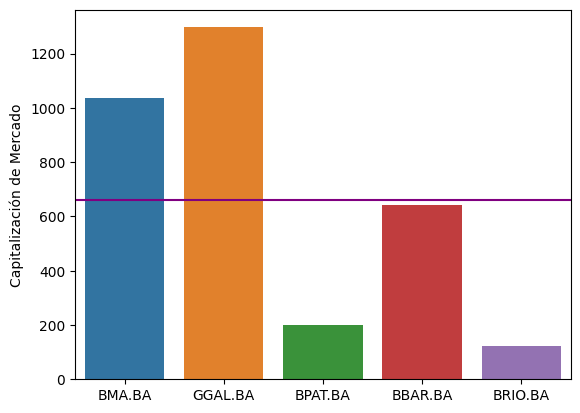

In [11]:
barras = sns.barplot(
    data=empresas_df, x=empresas_df.index, y=empresas_df["Capitalización de Mercado"]
)
barras.axhline(empresas_df["Capitalización de Mercado"].mean(), color="purple")
plt.show()

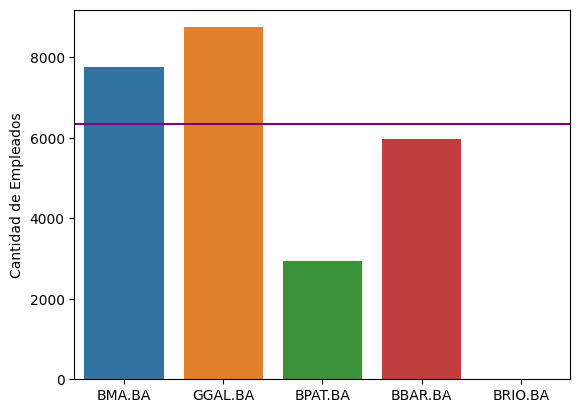

In [12]:
barras = sns.barplot(
    data=empresas_df, x=empresas_df.index, y=empresas_df["Cantidad de Empleados"]
)
barras.axhline(empresas_df["Cantidad de Empleados"].mean(), color="purple")
plt.show()

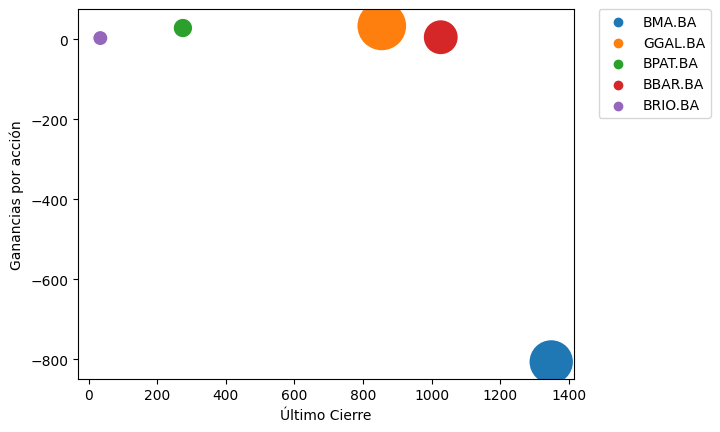

In [13]:
scatter = sns.scatterplot(
    data=empresas_df,
    x=empresas_df["Último Cierre"],
    y=empresas_df["Ganancias por acción"],
    s=empresas_df["Capitalización de Mercado"],
    hue=empresas_df.index,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

# 2- Pandas-datareader
**Instalación para Jupyter:**
    pip install pandas-datareader<br>
**Instalación para Colab:** !pip install --upgrade pandas_datareader<br>
En caso de no funcionar, volver a ejecutar tras haber reiniciado el entorno de ejecución.
**Documentación:**
    https://pandas-datareader.readthedocs.io/en/latest/

In [ ]:
comienzo = datetime.datetime(2020, 1, 1)
final = datetime.datetime(2021, 12, 7)

df = web.DataReader("NFLX", "yahoo", comienzo, final)
df.tail()

In [ ]:
import requests

comienzo = datetime.datetime(2020, 1, 1)
final = datetime.datetime(2021, 12, 7)

session = requests.Session()
session.request("GET", "https://finance.yahoo.com", timeout=10)

df = web.DataReader("NFLX", "yahoo", comienzo, final, session=session)

In [ ]:
# # Establecemos el inicio del período bajo análisis:
# comienzo = datetime.datetime(2022, 1, 1)

# # Establecemos el final del período bajo análisis:
# final = datetime.datetime(2022, 12, 31)
# df = yf.Ticker("NFLX")

# # Introducimos los parámetros para obtener la información:
# print(df.history(start=comienzo, end=final))

In [ ]:
df["Adj Close"].plot()

In [ ]:
total_df = web.DataReader(
    ["FB", "AMZN", "AAPL", "NFLX", "GOOG", "MSFT"], "yahoo", start=comienzo, end=final
)["Adj Close"]
total_df.head()

In [ ]:
total_df.tail()

### Calculamos si hay Correlación

In [ ]:
correl = total_df.corr()
correl

In [ ]:
plt.imshow(correl, cmap="hot", interpolation="None")  # probar interpolation = 'quadric'
plt.colorbar()
plt.xticks(range(len(correl)), correl.columns)
plt.yticks(range(len(correl)), correl.columns)
plt.show()

### Data Readers Disponibles
<br> Banco Mundial
<br> Reserva Federal de EE.UU.
<br> OCDE
<br>https://pandas-datareader.readthedocs.io/en/latest/readers/index.html

# 3- Scikit-Learn

In [ ]:
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import matplotlib as mpl
from matplotlib import style

In [ ]:
# pd.options.display.width = 0
# Vamos a trabajar con Datos de Netflix (NFLX).
# Por si quieren probar con otros datos, también subí archivos de Disney (DIS) y Bitcoin (BTC-USD)
NFLX_df = pd.read_csv("NFLX.csv")
print(NFLX_df.head())

close_px = NFLX_df["Adj Close"]

# Preparo un DataFrame con menos datos
shorter_df = NFLX_df.loc[:, ["Adj Close", "Volume"]]

In [ ]:
shorter_df.head()

In [ ]:
# Chequear si hay algún Nan
shorter_df.isnull().values.any()

In [ ]:
# Nos deshacemos de los Nan
# shorter_df.fillna(value=-99999, inplace=True)

In [ ]:
# Calculo cuánto es el 1%, respecto de los datos para predecir
separados_1p = int(math.ceil(0.01 * len(shorter_df)))

# Separamos el "precio de cierre ajustado"
forecast_col = "Adj Close"
shorter_df["label"] = shorter_df[forecast_col].shift(-separados_1p)
X = np.array(shorter_df.drop(["label"], 1))

# Hacemos un preprocesamiento de X, para que tengan la misma distribución para Regresión Lineal
X = preprocessing.scale(X)

# Preparamos X para la generación y evaluación del modelo
X_lately = X[-separados_1p:]
X = X[:-separados_1p]

# Separamos a label y lo identificamos como y
y = np.array(shorter_df["label"])
y = y[:-separados_1p]

In [ ]:
# Separamos los datos para Train y test, en un 80% - 20%
train, test = train_test_split(NFLX_df, test_size=0.20)

# Hacemos un Reshape a X_train
X_train = np.array(train.index).reshape(-1, 1)
y_train = train["Adj Close"]

# Regresión Lineal
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Regresión Cuadrática
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# KNN
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

X_test = np.array(test.index).reshape(-1, 1)
y_test = test["Adj Close"]

# Generamos un array de Y con los valores que se predicen
y_pred_reg = clfreg.predict(X_test)
y_pred_poly2 = clfpoly2.predict(X_test)
y_pred_knn = clfknn.predict(X_test)

### Predicción mediante Regresión Lineal

In [ ]:
plt.scatter(y_test, y_pred_reg)

plt.xlabel("Precio Real")
plt.ylabel("Predicciones")

plt.title("Predicción mediante Regresión Lineal")
plt.grid()
plt.show()

### Predicción mediante Regresión Cuadrática

In [ ]:
plt.scatter(y_test, y_pred_poly2)
plt.grid()
plt.xlabel("Precio Real")
plt.ylabel("Predicciones")

plt.title("Predicción mediante Regresión Cuadrática")

plt.show()

### Predicción mediante KNN

In [ ]:
plt.scatter(y_test, y_pred_knn)
plt.grid()
plt.xlabel("Precio Real")
plt.ylabel("Predicciones")

plt.title("Predicción mediante KNN")

plt.show()